## Text Classification Using Proposed CNN-GNN on AG-News

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize, TweetTokenizer
from torch_scatter import scatter_max, scatter_mean, scatter_sum, scatter_std
import torchmetrics
import lightning as L
from torch_geometric.data import Batch, Data
from copy import copy
import spacy
import string
import random
import math
import pickle 
from torch.utils.flop_counter import FlopCounterMode
from transformers import AutoModel, DebertaV2Tokenizer, AutoTokenizer
import matplotlib.pyplot as plt
from torch_geometric.nn import GATv2Conv, summary
from tqdm import tqdm
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss
from torchmetrics import ConfusionMatrix
from codes.scripts.utilities import ClassifierModelManager


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_embedding=12288
device

device(type='cuda')

In [3]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large")
id_vocab = {v:k for k,v in tokenizer.vocab.items()}
all_vocab_indices = list(id_vocab.keys())

with open('Data\ReducedEmbeddings\deberta_larg_reduced_embeddings_64.npy', 'rb') as f:
    embeddings = np.load(f)
embeddings = torch.from_numpy(embeddings)
# embeddings = (embeddings - torch.min(embeddings)) / (torch.max(embeddings)-torch.min(embeddings))
all_vocab_str = []
for i in range(len(id_vocab)):
    all_vocab_str.append(id_vocab[i])
token_vocab_dict = dict(zip(all_vocab_str, embeddings))

with open(r'Data\ReducedEmbeddings\polarity_debertav3_tokens_gpt_mini_emb.npy', 'rb') as f:
    polarities_subjectivities= np.load(f)
polarities_subjectivities = torch.from_numpy(polarities_subjectivities)
polarity_vocab_dict = dict(zip(all_vocab_str, polarities_subjectivities))
polarity_vocab_dict['<n>'] = torch.tensor([0.0, 0.0])
len(token_vocab_dict)
polarities_subjectivities.shape
for i in range(len(all_vocab_str)):
    if 'nice' in all_vocab_str[i]:
        print(i, polarities_subjectivities[i])
        break

f:\Articles\CGNet\venv\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


1085 tensor([0.7000, 0.6000], dtype=torch.float64)


In [24]:
test_df1 = pd.read_csv(r'data\TextClassification\AGNews\test.csv', header=None)
test_df1['Topic'] = test_df1[0] - 1
test_df1['Content'] = test_df1[1] + test_df1[2]
test_df1 = test_df1.sample(frac=1).reset_index(drop=True)

train_df1 = pd.read_csv(r'data\TextClassification\AGNews\train.csv', header=None)
train_df1['Topic'] = train_df1[0] - 1
train_df1['Content'] = train_df1[1] + train_df1[2]


train_df1 = train_df1.sample(frac=1).reset_index(drop=True)
train_df1 = train_df1.iloc[:train_df1.shape[0]-1200]
val_df1 = train_df1.iloc[train_df1.shape[0]-1200:train_df1.shape[0]]

In [25]:
batch_size = 400
test_df = test_df1.iloc[:batch_size * math.floor(test_df1.shape[0]/batch_size)]
train_df = train_df1.iloc[:batch_size * math.floor(train_df1.shape[0]/batch_size)]
val_df = val_df1.iloc[:batch_size * math.floor(val_df1.shape[0]/batch_size)]

print(f'traind_df diff: {train_df1.shape[0]-train_df.shape[0]}')
print(f'val_df diff: {val_df1.shape[0]-val_df.shape[0]}')
print(f'test_df diff: {test_df1.shape[0]-test_df.shape[0]}')

traind_df diff: 0
val_df diff: 0
test_df diff: 0


In [26]:
ag_classes = ["World", "Sports", "Business", "Sci/Tech"]
df = pd.concat([train_df1, val_df1, test_df1])
class_list = df.Topic.unique()
class_id = {ag_classes[i]:i for i in class_list}
id_class = {i:ag_classes[i] for i in class_list}

In [27]:
with open(r'Data\ReducedEmbeddings\term_frequencies.pkl', 'rb') as f:
    term_frequencies = pickle.load(f)

In [28]:
threshold = 0.00001
total_token_count = np.array(list(term_frequencies.values())).sum()
one_tensor = torch.tensor(1)
def subsampling_equation_linear(x: torch.Tensor):
    f_x = x/total_token_count
    x = torch.min(one_tensor, torch.sqrt_(threshold/f_x))
    return x

def subsampling_equation_sigmoid(x: torch.Tensor):
    f_x = x/total_token_count
    x = 1-0.95*F.sigmoid(0.05*((f_x/threshold)-90))
    return x


In [29]:
class CharacterandTokenLevelCustomDataset(Dataset):
    
    def __init__(self, X, y, num_classes, token_dict, sentiment_dict, tokenizer, token_frequencies, sampling_equation, shuffle=True, batch_size=128) -> None:
        super().__init__()
        # y = y[indices].values
        # y = torch.from_numpy(np.array([class_id[c] for c in y], dtype=np.longlong))
        
        # print(f'self.num_sections1: {len(y) // batch_size}')
        # self.sampling_equation = sampling_equation
        if len(y) % batch_size != 0:
            self.shortage = ((len(y) // batch_size)+1)*batch_size - len(y)
            empty_labels = [i%2 for i in range(self.shortage)]
            empty_strings = [id_class[l] for l in empty_labels]
            
            # print(f'y1 - {y.shape}: {y}')
            y = np.concatenate([y, empty_labels])
            # print(f'y2 - {y.shape}: {y}')
            # print(f'X1 - {X.shape}: {X}')
            X = np.concatenate([X, empty_strings])
        #     print(f'X2 - {X.shape}: {X}')
        
        # print(f'self.num_sections2: {len(y) // batch_size}')
        
        y = torch.from_numpy(y)
        self.shuffle = shuffle
        self.y = torch.nn.functional.one_hot(y, num_classes=num_classes).float()
        self.X = X
        # self.char_dict = char_dict
        # self.char_Set = set(char_dict.keys())
        # self.vocab_size = len(self.char_dict)
        self.tokenizer = tokenizer
        self.token_dict = token_dict
        self.sentiment_dict = sentiment_dict
        self.token_frequencies = token_frequencies
        self.max_token_count = 0
        
        
        self.all_data = []
        self.token_lengths = []
        self.token_embeddign_ids = []
        
        self.sum_a = 0
        
        for doc in tqdm(self.X):
            g_data = self.content_to_graph(doc, sampling_equation)
            self.all_data.append(g_data)
        
        
        self.num_sections = len(y) // batch_size
        self.x_lengths = np.array([self.all_data[i].character_length for i in range(len(self.all_data))])
        self.x_len_args = np.argsort(self.x_lengths)[::-1]
        
        self.section_ranges = np.linspace(0, len(self.x_len_args), self.num_sections+1)
        self.section_ranges = [(int(self.section_ranges[i-1]), int(self.section_ranges[i])) for i in range(1, len(self.section_ranges))]

        self.position_j = 0
        self.section_i = 0
        self.epoch = 0
        self.each_section_i = np.zeros((self.num_sections, ), dtype=int)
        
        self.sections, self.section_size = self.split_into_k_groups(self.x_len_args, self.x_lengths, self.num_sections)
        
    def __getitem__(self, index):
        index = self.get_section_index()
        return self.all_data[index], self.y[index]
        
    def __len__(self):
        return len(self.y)
    
    def get_section_index(self):
        # if self.shuffle:
            
        #     t_range = self.section_ranges[self.section_i]
        #     target_index = np.random.randint(t_range[0], t_range[1])
        # else:
        #     t_range = self.section_ranges[self.section_i]
        #     target_index = t_range[0] + self.each_section_i[self.section_i]
        #     self.each_section_i[self.section_i] = (self.each_section_i[self.section_i] + 1) % (t_range[1] - t_range[0])
        # print()
        # print(f'self.section_i: {self.section_i},   self.position_j: {self.position_j}')
        target_index = self.sections[self.section_i, self.position_j]
        
        self.position_j = (self.position_j + 1) % self.section_size
        if self.position_j == 0:
            self.section_i = (self.section_i + 1) % self.num_sections
            if self.shuffle and self.section_i == 0:
                self.sections, self.section_size = self.split_into_k_groups(self.x_len_args, self.x_lengths, self.num_sections)
                # random_positions = np.random.choice(np.arange(0, self.section_size), size=self.section_size, replace=False)
        # return self.x_len_args[target_index]
        return target_index

    def reset_params(self):
        self.section_i = 0
        self.position_j = 0
        self.each_section_i = np.zeros((self.num_sections, ), dtype=int)
        
    def split_into_k_groups(self, len_sorted_args, lengths:np.array, k):
        if self.shuffle and self.epoch > 0:
            randomize_sections = np.concatenate([np.random.choice(np.arange(r[0], r[1]), size=r[1]-r[0], replace=False) for r in self.section_ranges])
            len_sorted_args = len_sorted_args[randomize_sections]
        
        nums = lengths[len_sorted_args]
        groups_size = len(len_sorted_args) // k
        
        
        groups = [[] for _ in range(k)]
        group_sums = np.zeros(k, dtype=int)
        group_sizes = np.zeros(k, dtype=int)
        
        # print(f'groups_size: {groups_size}')
        # print(f'len(len_sorted_args): {len(len_sorted_args)}')
        # print(f'k: {k}')
        for i, num in enumerate(nums):
            candidate_indices = np.where(group_sizes<groups_size)[0]
            # print(f'candidate_indices: {candidate_indices}')
            min_group_idx = candidate_indices[np.argmin(group_sums[candidate_indices])]
            groups[min_group_idx].append(len_sorted_args[i])
            group_sums[min_group_idx] += num
            group_sizes[min_group_idx] += 1
        self.epoch += 1
        
        groups = np.array(groups)
        group_sums_argsort = np.argsort(group_sums)[::-1]
        groups = groups[group_sums_argsort]
        
        # check_x = self.X[groups]
        # check_x_lens = [np.sum(np.array([len(sx) for sx in rx])) for rx in check_x]
        # print(f'check_x: {check_x}')
        
        
        return np.array(groups), groups_size
        
    def content_to_graph(self, doc, sampling_equation):
        # tokens = self.tokenizer(''.join(c for c in doc if c in self.char_Set))
        # tokens = [t.text for t in tokens]
        tokens = self.tokenizer(doc)
        if len(tokens) == 0:
            tokens = ['empty']
                        
        token_lengths = [len(t) for t in tokens]
        tokens.append('')
        
        token_lengths.append(len(tokens[-1])-1)
        token_lengths = torch.from_numpy(np.array(token_lengths, dtype=np.longlong))+1
        token_embs = [self.token_dict[t] if t in self.token_dict else torch.zeros((64, ), dtype=torch.float32) for t in tokens]
        token_sentiments = [self.sentiment_dict[t] if t in self.sentiment_dict else (0.0, 0.0) for t in tokens]
        token_embs = torch.from_numpy(np.array(token_embs, dtype=np.float32))
        token_sentiments = torch.from_numpy(np.array(token_sentiments, dtype=np.float32))
        doc = ' '.join(tokens)
        characters = torch.from_numpy(np.array([ord(t) if ord(t)<num_embedding else (num_embedding-1) for t in doc], dtype=np.longlong))
        token_positions = torch.arange(len(token_lengths), dtype=torch.long)
        token_indices = torch.repeat_interleave(token_positions, token_lengths)
        token_subsampling_probabilities = sampling_equation(torch.from_numpy(np.array([self.token_frequencies[t] if t in self.token_frequencies else 1 for t in tokens])))
        num_tokens = len(token_lengths)
        if num_tokens > self.max_token_count:
            self.max_token_count = num_tokens
        g_data = Data(x=characters,
                        token_positions=token_positions,
                        character_length = len(characters),
                        num_tokens = num_tokens,
                        token_indices=token_indices,
                        token_lengths=token_lengths,
                        token_embeddings=token_embs,
                        token_sentiments=token_sentiments,
                        token_subsampling_probabilities=token_subsampling_probabilities)
        return g_data
 
    def caluculate_batch_token_positions(self, num_tokens, character_length, token_indices):
        cumsum_vals = torch.cumsum(num_tokens, dim=0).roll(1)
        cumsum_vals[0] = 0
        additions = torch.repeat_interleave(cumsum_vals, character_length)
        cumulative_token_indices = token_indices + additions
        return cumulative_token_indices       

In [30]:
from typing import List
import torch
from torch_geometric.loader import DataLoader

class CharacterandTokenLevelDataLoader(DataLoader):
    def __init__(
        self,
        dataset,
        batch_size: int = 1,
        shuffle: bool = False,
        follow_batch: List[str] | None = None,
        exclude_keys: List[str] | None = None,
        **kwargs,
    ):
        super(CharacterandTokenLevelDataLoader, self).__init__(
            dataset, batch_size, shuffle, follow_batch, exclude_keys, **kwargs
        )

    def __iter__(self):
        base_iterator = super(CharacterandTokenLevelDataLoader, self).__iter__()
        for batch in base_iterator:
            cumsum_vals = torch.cumsum(batch[0].num_tokens, dim=0).roll(1)
            cumsum_vals[0] = 0
            additions = torch.repeat_interleave(cumsum_vals, batch[0].character_length)
            batch[0].cumulative_token_indices = batch[0].token_indices + additions
            yield batch


In [31]:
%%time
train_dataset = CharacterandTokenLevelCustomDataset(train_df.Content.values, train_df.Topic.values, len(class_id), token_vocab_dict, polarity_vocab_dict, tokenizer.tokenize, token_frequencies=term_frequencies, sampling_equation=subsampling_equation_sigmoid, batch_size=batch_size)
test_dataset = CharacterandTokenLevelCustomDataset(test_df.Content.values, test_df.Topic.values, len(class_id), token_vocab_dict, polarity_vocab_dict, tokenizer.tokenize, token_frequencies=term_frequencies, sampling_equation=subsampling_equation_sigmoid, batch_size=batch_size)
max_token_count = max(train_dataset.max_token_count, test_dataset.max_token_count)
train_dataloader = CharacterandTokenLevelDataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
dummy_dataloader = CharacterandTokenLevelDataLoader([(Batch.from_data_list([train_dataset[i][0]]), train_dataset[i][1]) for i in range(batch_size)], batch_size=batch_size, drop_last=False, shuffle=False)

  0%|          | 13/118800 [00:00<15:57, 124.04it/s]

100%|██████████| 7600/7600 [00:35<00:00, 213.18it/s]


CPU times: total: 35min 51s
Wall time: 11min 36s


In [32]:
X, y = next(iter(dummy_dataloader))

## Model Classes and Functions

In [33]:
class GCNN(nn.Module):
    def __init__(self, hidden_dim, edge_dim=None, *args, **kwargs):
        super(GCNN, self).__init__(*args, **kwargs)
        self.gnn = GATv2Conv(hidden_dim, hidden_dim//8, heads=4, edge_dim=edge_dim, add_self_loops=False)
        self.conv = nn.Conv1d(hidden_dim, hidden_dim//2, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_dim//2, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim//2)
        
    def forward(self, x, edge_data, edge_attr=None, return_attention_weights = False):
        x1, edge_weights = self.gnn(x, edge_data, edge_attr=edge_attr, return_attention_weights=return_attention_weights) 
        x2 = F.relu(self.conv(x.T).T)
        x1 = F.leaky_relu_(self.bn1(x1))
        x = torch.cat([x1, x2], dim=1)
        return x, edge_weights, edge_data

In [34]:
from utilities.model_layers.SentimentInjection import SentimentInjection

In [35]:
class GenGraph(nn.Module):
    
    def __init__(self, hidden_dim, virtual_nodes, lattice_step, lattice_pattern=None, head=4, *args, **kwargs):
        super(GenGraph, self).__init__(*args, **kwargs)
        self.hidden_dim = hidden_dim
        self.head = head
        self.virtual_nodes = virtual_nodes
        self.lattice_step = lattice_step
        # lp: lattice pattern
        self.lp = lattice_pattern if lattice_pattern is None else torch.tensor(lattice_pattern)
        self.virtual_node_embeddings = nn.Embedding(self.virtual_nodes, hidden_dim)
        
    def gen_graph(self, x, token_subsampling_probabilities, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance=2):
        random_links, lattice_links, token_batch_idx = self.calculate_graph(x, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance)
        v_n_e_counts = total_token_counts*self.virtual_nodes
        base_numel = random_links.numel() + lattice_links.numel()*2
        edge_indices = torch.empty((2, base_numel + v_n_e_counts*2), dtype=torch.int64, device=x.device)
        self.fill_lattice_and_random_edges(edge_indices, random_links, lattice_links, token_batch_idx)
            
        if self.virtual_nodes > 0:
            virtual_nodes_range = torch.arange(self.virtual_nodes, device=x.device).view(1, -1)
            virtual_nodes_ids = torch.repeat_interleave(virtual_nodes_range, len(token_counts), dim=0)
            v_n_idx = (virtual_nodes_ids + torch.arange(0, len(token_counts)*self.virtual_nodes, self.virtual_nodes, device=x.device).view(-1, 1) + total_token_counts )
            virtual_edge_ids = torch.repeat_interleave(v_n_idx.view(-1), token_counts.view(-1, 1).expand(len(token_counts), self.virtual_nodes).reshape(-1), dim=0).view(1, -1)
            
            embs = self.virtual_node_embeddings(virtual_nodes_ids.T).view(-1, self.hidden_dim)
            x_extended = torch.cat([x, embs], dim=0)
            x_index = torch.arange(total_token_counts, device=x.device).repeat(self.virtual_nodes).view(1, -1)
            edge_indices[:, base_numel:base_numel+v_n_e_counts] = torch.cat([x_index, virtual_edge_ids], dim=0)
            edge_indices[:, base_numel+v_n_e_counts:] = torch.cat([virtual_edge_ids, x_index], dim=0)
            x = x_extended
        
        edge_indices = self.subsample_edges(edge_indices, token_subsampling_probabilities)
        return Batch.from_data_list([Data(x=x, edge_index=edge_indices)])
        
    def re_gen_graph(self, x, edge_indices, token_subsampling_probabilities, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance=2):
        random_links, lattice_links, token_batch_idx = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance)
        base_numel = random_links.numel() + lattice_links.numel()*2
        
        self.fill_lattice_and_random_edges(edge_indices, random_links, lattice_links, token_batch_idx)
        # for i in range(base.shape[1]):
        #     edge_indices[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([token_batch_idx, base[:,i].view(1,-1)], dim=0)
        edge_indices = self.subsample_edges(edge_indices, token_subsampling_probabilities)
        return Batch.from_data_list([Data(x=x, edge_index=edge_indices)])
    
    def replace_unimportant_edges(self, edge_weights, x, edge_indices, token_subsampling_probabilities, total_token_counts, token_counts, random_edges, lattice_edges, p_keep=1, lattice_start_distance=2):
        v_n_e_counts = total_token_counts*self.virtual_nodes
        # if v_n_e_counts>0:
        #     important_indices = torch.topk(edge_weights[:-2*v_n_e_counts].view(-1, total_token_coutns), p_keep, dim=0).indices
        # else:
        #     print(f'edge_weights.shape: {edge_weights.shape}')
        #     print(f'total_token_coutns: {total_token_coutns}')
        #     print(f'p_keep: {p_keep}')
        #     important_indices = torch.topk(edge_weights.view(-1, total_token_coutns), p_keep, dim=0).indices
        # important_indices = torch.topk(edge_weights[:-1*total_token_coutns].view(-1, total_token_coutns), 1, dim=0).indices.squeeze()
        # print(f'edge_weights.shape: {edge_weights.shape}')
        # print(f'edge_indices.shape: {edge_indices.shape}')
        # print(f'1: edge_weights: {edge_weights.shape}')
        important_indices = torch.topk(edge_weights.squeeze(), p_keep*total_token_counts, dim=0).indices
        # print(f'2: important_indices: {important_indices.shape}')
        # print(f'2.5: \n {edge_weights} \n\n {important_indices}')

        # important_indices = torch.arange(total_token_counts, dtype=torch.int64, device=x.device)
        # important_indices = important_indices.view(-1)
        random_links, lattice_links, token_batch_idx = self.calculate_graph(x, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance)
        # print(f'3: random_links: {random_links.shape}, lattice_links: {lattice_links.shape}, token_batch_idx: {token_batch_idx.shape},')
        base_numel = random_links.numel() + lattice_links.numel()*2
        # print(f'4: base_numel: {base_numel}')
        
        new_edge_index = torch.empty((2, base_numel + important_indices.shape[0] + 2*v_n_e_counts), dtype=torch.int64, device=x.device)
        # print(f'5: new_edge_index: {new_edge_index.shape}')
        # print(f'new_edge_index.shape 1: {new_edge_index.shape}, base_numel + important_indices.shape[0] + 2*v_n_e_counts: {base_numel + important_indices.shape[0] + 2*v_n_e_counts}')
        self.fill_lattice_and_random_edges(new_edge_index, random_links, lattice_links, token_batch_idx)
        # print(f'6: new_edge_index: {new_edge_index.shape}, random_links: {random_links.shape}, lattice_links: {lattice_links.shape}, token_batch_idx: {token_batch_idx.shape}')
        # print(f'new_edge_index.shape 2: {new_edge_index.shape}, edge_indices: {edge_indices.shape}, important_indices shape: {important_indices.shape}, important_indices max: {important_indices.max()}')
        new_edge_index[:, base_numel:base_numel+important_indices.shape[0]] = edge_indices[:, important_indices]
        # print(f'7: new_edge_index: {new_edge_index.shape}')

        if(self.virtual_nodes>0):
            new_edge_index[:, -2*v_n_e_counts:] = edge_indices[:, -2*v_n_e_counts:]
            
        # for i in range(base.shape[1]):
        #     new_edge_index[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([token_batch_idx, base[:,i].view(1,-1)], dim=0)
        # print(f'7.5: \n {new_edge_index} \n\n {token_subsampling_probabilities}')
        new_edge_index = self.subsample_edges(new_edge_index, token_subsampling_probabilities)
        
        return Batch.from_data_list([Data(x=x, edge_index=new_edge_index)])
    
        
    def calculate_graph(self, x, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance):

        tc_extended = torch.repeat_interleave(token_counts, token_counts, dim=0).view(-1,1)
        tc_lower_bound = torch.empty((len(token_counts)+1), dtype=torch.long, device=x.device) #torch.cuda.IntTensor(len(token_counts)+1) #
        tc_lower_bound[0] = 0
        tc_lower_bound[1:] = torch.cumsum(token_counts, dim=0)
        tc_lower_bound_extended = torch.repeat_interleave(tc_lower_bound[:-1], token_counts, dim=0).view(-1,1)
        # token_batch_idx range from zero to character counts in the x !
        token_batch_idx = torch.arange(tc_lower_bound[-1], device=x.device).view(-1,1)
        # torch.arange(tc_lower_bound[-1], dtype=torch.int32, device=x.device).view(-1,1)
        
        random_ints = torch.randint(0, 2*total_token_counts, (total_token_counts, random_edges), device=x.device) # torch.cuda.IntTensor(len(token_lengths), random_edges).random_()
        lattice = self.lp.to(x.device) if self.lp is not None else torch.arange(lattice_start_distance, max(lattice_start_distance, self.lattice_step*lattice_edges+1), self.lattice_step, device=x.device).view(1, -1)
        

        # exponentials = torch.pow(2, torch.arange(1, self.exp_edges+1, device=x.device)).view(1, -1)
        tc_local_range = token_batch_idx - tc_lower_bound_extended
        random_links = (((random_ints % (tc_extended - 1))+1 + tc_local_range) % tc_extended)+tc_lower_bound_extended
        lattice_links = ((lattice + tc_local_range) % tc_extended)+tc_lower_bound_extended
        
        # base = torch.cat([base1, base2], dim=1)
        token_batch_idx = token_batch_idx.view(1,-1)
        return random_links, lattice_links, token_batch_idx
    
    def fill_lattice_and_random_edges(self, edge_indices, random_links, lattice_links, token_batch_idx):
        for i in range(0, lattice_links.shape[1]*2, 2):
            edge_indices[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]] = torch.cat([lattice_links[:,i//2].view(1,-1), token_batch_idx], dim=0)
            edge_indices[:, (i+1)*lattice_links.shape[0]:(i+2)*lattice_links.shape[0]] = edge_indices[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]][[1, 0]]
            
        for i in range(random_links.shape[1]):
            j = i + lattice_links.shape[1]*2
            edge_indices[:, j*random_links.shape[0]:(j+1)*random_links.shape[0]] = torch.cat([random_links[:,i].view(1,-1), token_batch_idx], dim=0)
            
    def subsample_edges(self, edge_indices, token_subsampling_probabilities, keep_ratio=0.5):
        top_k_indices = torch.topk(torch.sum(token_subsampling_probabilities[edge_indices], dim=0), int(keep_ratio*edge_indices.shape[1]/self.head), dim=0).indices
        edge_indices = edge_indices[:, top_k_indices].reshape(2, -1)
        return edge_indices

In [36]:
class CGNetEmbedding(nn.Module):
    def __init__(self, embedding_dim=64, hidden_dim=64, dropout=0.2, seed=-1, random_edges=4, lattice_edges=10, lattice_step=2, lattice_start_distance=2, inject_embedding_dim=64, step_of_test = 0, head=4, *args, **kwargs):
        super(CGNetEmbedding, self).__init__(*args, **kwargs)
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.base_random_edges = random_edges
        self.base_lattice_edges = lattice_edges
        self.lattice_start_distance = lattice_start_distance
        self.step_of_test = step_of_test
        if seed>-1:
            torch.manual_seed(seed)
        self.embedding = nn.Embedding(16384, embedding_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(2*hidden_dim + 2, hidden_dim, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.sentiment1  = SentimentInjection(hidden_dim, hidden_dim)
        self.sentiment2  = SentimentInjection(hidden_dim, hidden_dim)
        self.p_layer_1 = nn.Linear(hidden_dim, head)
        self.gcnn1 = GCNN(hidden_dim)
        self.p_layer_2 = nn.Linear(hidden_dim, head)
        self.gcnn2 = GCNN(hidden_dim+inject_embedding_dim)
        self.graph_generator = GenGraph(hidden_dim, 0, lattice_step, head=head)
        self.fc0 = nn.Linear(hidden_dim , hidden_dim+inject_embedding_dim)
        self.fc1 = nn.Linear(hidden_dim+inject_embedding_dim , hidden_dim * 4)
        self.fc2 = nn.Linear(hidden_dim * 2 * 4 , hidden_dim)
    
    def forward(self, x, edge_index, token_subsampling_probabilities, token_indices, token_sentiments, token_lengths, num_tokens, character_length, token_embeddings):
        cumulative_token_indices = self.caluculate_batch_token_positions(num_tokens, character_length, token_indices)
        x = self.embedding(x)
        x = self.dropout(x)
        x = x.T
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x1 = scatter_max(x, cumulative_token_indices, dim=1)[0]
        x2 = scatter_mean(x, cumulative_token_indices, dim=1)
        x = torch.cat([x1, x2, token_sentiments.T], dim=0)
        x = F.relu(self.conv3(x))
        x = self.sentiment1(x.T, token_sentiments)
        rand_edges, lattice_edges = self.base_random_edges, self.base_lattice_edges
        p = self.p_layer_1(x.T)
        p = F.softmax(p, dim=1)
        ids = torch.argmax(p, dim=1, keepdim=True)
        p = torch.zeros_like(p).scatter_(1, ids, torch.ones_like(p)) * token_subsampling_probabilities.unsqueeze(1)
        graph = self.graph_generator.gen_graph(x, p, len(token_lengths), num_tokens, rand_edges, lattice_edges, lattice_start_distance=self.lattice_start_distance)
        x, edge_weights, edge_index = self.gcnn1(graph.x.T, graph.edge_index, return_attention_weights = True)
        edge_weights = edge_weights[1].unsqueeze(-1)
        edge_weights = edge_weights[:edge_weights.shape[0], 0]
        
        p = self.p_layer_2(x)
        p = F.softmax(p, dim=1)
        ids = torch.argmax(p, dim=1, keepdim=True)
        p = torch.zeros_like(p).scatter_(1, ids, torch.ones_like(p)) * token_subsampling_probabilities.unsqueeze(1)
        graph = self.graph_generator.replace_unimportant_edges(edge_weights, x, edge_index, p, len(token_lengths), num_tokens, rand_edges-1, lattice_edges-1, p_keep=2, lattice_start_distance=self.lattice_start_distance+1)
        x = self.sentiment2(x, token_sentiments)
        xa = graph.x[:token_embeddings.shape[0]]
        xb = token_embeddings
        x = torch.cat([xa, xb], dim=1)
        x1 = F.relu(self.fc0(graph.x[token_embeddings.shape[0]:]))
        x = torch.cat([x, x1], dim=0)
        
        x, edge_weights, edge_index = self.gcnn2(x, graph.edge_index)
        
        x = F.elu_(self.fc1(x))
        doc_token_index = torch.repeat_interleave(torch.arange(len(num_tokens), device=x.device), num_tokens)
        x1 = scatter_max(x[:len(token_lengths)], doc_token_index, dim=0)[0]
        x2 = scatter_mean(x[:len(token_lengths)], doc_token_index, dim=0)
        x = torch.cat([x1, x2], dim=1)
        x = self.fc2(x)
        return x
    
    def caluculate_batch_token_positions(self, num_tokens, character_length, token_indices):
        cumsum_vals = torch.cumsum(num_tokens, dim=0).roll(1)
        cumsum_vals[0] = 0
        additions = torch.repeat_interleave(cumsum_vals, character_length)
        cumulative_token_indices = token_indices + additions
        return cumulative_token_indices

In [37]:
class CNN_for_Text_No_Positional_Encoding(nn.Module):
    
    def __init__(self, embedding_model: CGNetEmbedding, hidden_dim=64, dropout=0.3, num_out_features=4, *args, **kwargs) -> None:
        super(CNN_for_Text_No_Positional_Encoding, self).__init__(*args, **kwargs)
        self.embedding_model = embedding_model
        self.num_out_features= num_out_features
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(hidden_dim, self.num_out_features)
    
    def forward(self, x, edge_index, token_subsampling_probabilities, token_indices, token_sentiments, token_lengths, num_tokens, character_length, token_embeddings):
        x = F.elu_(self.embedding_model(x, edge_index, token_subsampling_probabilities, token_indices, token_sentiments, token_lengths, num_tokens, character_length, token_embeddings))
        x = self.dropout(x)
        return self.fc_out(x)

In [38]:
from torch.utils.flop_counter import FlopCounterMode

embedding_model = CGNetEmbedding(embedding_dim=64, hidden_dim=64, dropout=0.2,  seed=-1, random_edges=4, lattice_edges=4, lattice_step=2, lattice_start_distance=2).eval()
classifier_torch_model = CNN_for_Text_No_Positional_Encoding(embedding_model, hidden_dim=64, dropout=0.2, num_out_features=len(class_id)).eval()
classifier_torch_model = classifier_torch_model.to(device)

num_total_params = sum(p.numel() for p in classifier_torch_model.parameters())
print(f'number of parameters: {num_total_params}')

# Flops for the batch size=224
flopt_counter = FlopCounterMode()
with flopt_counter:
    X.to(device)
    classifier_torch_model(X.x, torch.zeros((2, 0)), X.token_subsampling_probabilities, X.token_indices, X.token_sentiments, X.token_lengths, X.num_tokens, X.character_length, X.token_embeddings)

number of parameters: 1314732
Module                                                   FLOP    % Total
----------------------------------------------------  -------  ---------
CNN_for_Text_No_Positional_Encoding                   16.031B    100.00%
 - aten.convolution                                   13.799B     86.08%
 - aten.addmm                                          2.232B     13.92%
 CNN_for_Text_No_Positional_Encoding.embedding_model  16.031B    100.00%
  - aten.convolution                                  13.799B     86.08%
  - aten.addmm                                         2.232B     13.92%
 CNN_for_Text_No_Positional_Encoding.fc_out            0.000B      0.00%
  - aten.addmm                                         0.000B      0.00%


In [39]:
import torch
import lightning as L
import torchmetrics

class CGNetEmbeddingLightningModel(L.LightningModule):
    def __init__(
        self,
        model,
        num_classes,
        optimizer=None,
        loss_func=None,
        learning_rate=0.01,
        batch_size=64,
        lr_scheduler=None,
        user_lr_scheduler=False,
        min_lr=0.0,
    ):
        super(CGNetEmbeddingLightningModel, self).__init__()
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = model
        self.min_lr = min_lr
        # self.save_hyperparameters(ignore=["model"])
        self.save_hyperparameters(logger=False)
        self.optimizer = self._get_optimizer(optimizer)
        self.lr_scheduler = (
            self._get_lr_scheduler(lr_scheduler) if user_lr_scheduler else None
        )
        self.loss_func = loss_func
        self.train_losses = []
        self.val_losses = []
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x, *args, **kwargs):
        return self.model(x.x, torch.zeros((2, 0)), x.token_subsampling_probabilities, x.token_indices, x.token_sentiments, x.token_lengths, x.num_tokens, x.character_length, x.token_embeddings)

    def on_train_epoch_start(self) -> None:
        param_groups = next(iter(self.optimizer.param_groups))
        if "lr" in param_groups and param_groups["lr"] is not None:
            current_learning_rate = float(param_groups["lr"])
            self.log(
                "lr",
                current_learning_rate,
                batch_size=self.batch_size,
                on_epoch=True,
                on_step=False,
            )

    def training_step(self, batch, *args, **kwargs):
        X, y = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.train()
        y_out = self(X)

        loss = self.loss_func(y_out.view(y.shape), y )
        self.train_losses.append(loss.detach().item())
        self.log(
            "train_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        self.train_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('train_acc', self.train_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)
        
        return loss

    def validation_step(self, batch, *args, **kwargs):
        X, y = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.eval()
        y_out = self(X)
        loss = self.loss_func(y_out.view(y.shape), y )
        self.val_losses.append(loss.detach().item())

        self.log(
            "val_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        
        self.val_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('val_acc', self.val_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)

    def configure_optimizers(self):
        if self.lr_scheduler is None:
            return self.optimizer

        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": self.lr_scheduler,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

    def update_learning_rate(self, learning_rate: float):
        self.learning_rate = learning_rate
        for g in self.optimizer.param_groups:
            g["lr"] = learning_rate

    def _get_optimizer(self, optimizer):
        return (
            optimizer
            if optimizer is not None
            else torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        )

    def _get_lr_scheduler(self, lr_scheduler):
        return (
            lr_scheduler
            if lr_scheduler is not None
            else torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, patience=5, factor=0.5, mode="min", min_lr=self.min_lr
            )
        )


In [40]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torchmetrics import ConfusionMatrix

def calculate_metrics(cl_model, dataloader):
    cm = ConfusionMatrix(task="multiclass", num_classes=len(class_id))

    y_pred = []
    y_true = []

    cl_model = cl_model.eval()
    cl_model.to(device)
    for X, y in tqdm(dataloader):
        X = X.to(device)
        with torch.no_grad():
            y_p = cl_model(X)
            y_p = y_p.cpu()
        y_pred.append(y_p)
        y_true.append(y)
    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)
    y_pred2 = torch.argmax(y_pred, dim=1)
    y_true2 = torch.argmax(y_true, dim=1)
    print(f'classification report: \n {classification_report(y_true2, y_pred2, digits=4)}')
    print(f'confusion matrix:\n {cm(y_pred2, y_true2)}')
    print('================================')


## Test Model

In [41]:
output_size = 128
hidden_dim = 64
embedding_dim = 64
label_size = 1
seed = -1

In [42]:
def train_model(epochs=30, dropout=0.25, weight_decay=0.000012, lr=0.0002, amsgrad=False, fused=True):
    torch.autograd.set_detect_anomaly(True)
    
    embedding_model = CGNetEmbedding(embedding_dim=embedding_dim, hidden_dim=hidden_dim, dropout=dropout,  seed=seed, random_edges=6, lattice_edges=10, lattice_step=2, lattice_start_distance=2).to(device)
    classifier_torch_model = CNN_for_Text_No_Positional_Encoding(embedding_model, hidden_dim=hidden_dim, dropout=dropout, num_out_features=len(class_id)).to(device)
    
    # optimizer = torch.optim.Adam(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad, fused=fused)
    optimizer = torch.optim.AdamW(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad, fused=fused)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100, 150, 200, 250, 300, 350],gamma=0.5, verbose=False)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 20, 30, 40, 45,50,55],gamma=0.5, verbose=False)
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 20, 30, 38, 40,45,50],gamma=0.5, verbose=False)

    loss_func = torch.nn.BCEWithLogitsLoss()
    classfier_lightning_model = CGNetEmbeddingLightningModel(classifier_torch_model, 
                                                        num_classes=len(class_id),
                                                learning_rate=lr,
                                                batch_size=batch_size,
                                                optimizer=optimizer,
                                                loss_func=loss_func,
                                                lr_scheduler=lr_scheduler,
                                                user_lr_scheduler=True
                                                ).to(device)

    model_manager = ClassifierModelManager(classifier_torch_model, classfier_lightning_model, log_name='CNN-GNN13_large_models',device=device, num_train_epoch=epochs, accumulate_grad_batches=1)

    # trainer = L.Trainer(
    #             # callbacks=callbacks,
    #             max_epochs=epochs,
    #             accelerator= 'gpu' if torch.cuda.is_available() else 'cpu',
    #             logger=CSVLogger(save_dir='logs/', name='log2'), 
    #             num_sanity_val_steps=0,
    #         #     default_root_dir='models\model2_word_embedding-256-2'
    #         )

    # train_dataset.reset_params()
    # train_dataset.position_j = 0
    # test_dataset.reset_params()
    # test_dataset.position_j = 0
    
    # train_dataset.section_i = 0
    # train_dataset.each_section_i = np.zeros((train_dataset.num_sections, ), dtype=int)
    # test_dataset.section_i = 0
    # test_dataset.each_section_i = np.zeros((test_dataset.num_sections, ), dtype=int)
    
    model_manager.fit(train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss_epoch'], eval_names=['train_acc_epoch', 'val_acc_epoch'], name_prepend=f'tests_{dropout}_{weight_decay}_{lr}_{amsgrad}_{fused}')
    model_manager.torch_model = model_manager.torch_model.to(device)
    model_manager.save_evaluation(test_dataloader, f'{dropout}_{weight_decay}_{lr}]',True, True, True, True, True, True, True, multi_class=True)
    # trainer.fit(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    classfier_lightning_model.model = classfier_lightning_model.model.eval()
    classfier_lightning_model = classfier_lightning_model.eval()
    calculate_metrics(classfier_lightning_model, test_dataloader)
    model_manager.evaluate_best_models(CGNetEmbeddingLightningModel, test_dataloader,True, True, True, True, True, True, True, multi_class=True, model=classifier_torch_model, num_classes=len(class_id))
    return model_manager

In [43]:
torch.cuda.empty_cache()
import gc
gc.collect()

0

f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmu

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([7600, 4])
torch.Size([7600, 4])
torch.Size([7600])
torch.Size([7600])


100%|██████████| 19/19 [00:03<00:00,  4.95it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9414    0.9384    0.9399      1900
           1     0.9693    0.9811    0.9752      1900
           2     0.9129    0.8884    0.9005      1900
           3     0.8981    0.9142    0.9061      1900

    accuracy                         0.9305      7600
   macro avg     0.9304    0.9305    0.9304      7600
weighted avg     0.9304    0.9305    0.9304      7600

confusion matrix:
 tensor([[1783,   27,   46,   44],
        [  13, 1864,   14,    9],
        [  54,   14, 1688,  144],
        [  44,   18,  101, 1737]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([7600, 4])
torch.Size([7600, 4])
torch.Size([7600])
torch.Size([7600])


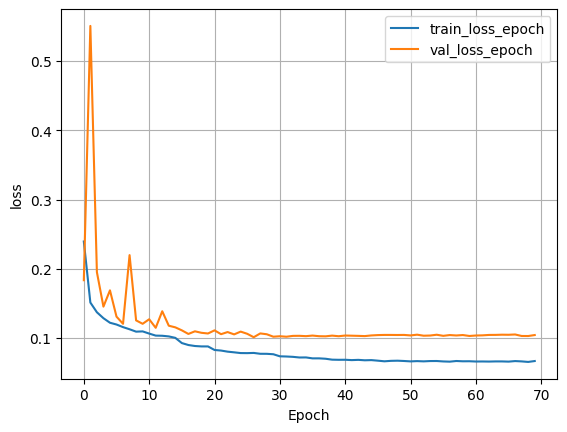

In [44]:
model_manager = train_model(70, 0.2, 0.000011, 0.0032, amsgrad=False, fused=True)

classification report:  <br/>
               precision    recall  f1-score   support <br/>

           0     0.9317    0.9358    0.9337      1792
           1     0.9729    0.9767    0.9748      1802
           2     0.9024    0.8781    0.8901      1789
           3     0.8938    0.9104    0.9020      1785

     accuracy     -         -         0.9254      7168 
    macro_avg     0.9252    0.9253    0.9252      7168 <br/>
    weighted_avg  0.9253    0.9254    0.9253      7168 <br/>

confusion matrix: <br/>
 tensor([[1677,   17,   59,   39], <br/>
        [  19, 1760,   13,   10], <br/>
        [  54,   20, 1571,  144], <br/>
        [  50,   12,   98, 1625]]) <br/>

In [ ]:
import time
for i in range(4):
    time.sleep(15)
    torch.cuda.empty_cache()
    import gc
    gc.collect()
    time.sleep(15)
    model_manager = train_model(70, 0.2, 0.000011, 0.0032, amsgrad=False, fused=True)

f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([7600, 4])
torch.Size([7600, 4])
torch.Size([7600])
torch.Size([7600])


100%|██████████| 19/19 [00:02<00:00,  6.64it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9450    0.9411    0.9430      1900
           1     0.9642    0.9789    0.9715      1900
           2     0.9069    0.8874    0.8970      1900
           3     0.9062    0.9158    0.9110      1900

    accuracy                         0.9308      7600
   macro avg     0.9306    0.9308    0.9307      7600
weighted avg     0.9306    0.9308    0.9307      7600

confusion matrix:
 tensor([[1788,   27,   47,   38],
        [  17, 1860,   15,    8],
        [  51,   29, 1686,  134],
        [  36,   13,  111, 1740]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([7600, 4])
torch.Size([7600, 4])
torch.Size([7600])
torch.Size([7600])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
def calculatge_metrics(chpt_path, target_data_loader, num_embedding):
    embedding_model = CGNetEmbedding(embedding_dim=embedding_dim, hidden_dim=hidden_dim, dropout=0.2,  seed=seed, random_edges=6, lattice_edges=10, lattice_step=2, lattice_start_distance=2).to(device)
    classifier_torch_model = CNN_for_Text_No_Positional_Encoding(embedding_model, hidden_dim=hidden_dim, dropout=0.2, num_out_features=len(class_id)).to(device)
    classfier_lightning_model = CGNetEmbeddingLightningModel.load_from_checkpoint(chpt_path, model=classifier_torch_model, num_classes=len(class_id)).eval()
    mean_infer_acc = []
    mean_infer_f1 = []
    mean_infer_prec = []
    mean_infer_rec = []
    for i in range(5):
        all_ys = []
        all_y_preds = []
        for X, y in target_data_loader:
            with torch.no_grad():
                y_pred = classfier_lightning_model(X.to(device))
            all_ys.append(torch.argmax(y,dim=1))
            all_y_preds.append(torch.argmax(y_pred.cpu(), dim=1))
        all_ys = torch.concat(all_ys)
        all_y_preds = torch.concat(all_y_preds)
        
        cm = confusion_matrix(all_ys, all_y_preds)
        
        accuracy = np.sum(np.diag(cm))/ np.sum(cm)
        precision = np.mean(np.diag(cm) / np.sum(cm, axis=0))
        recall = np.mean(np.diag(cm) / np.sum(cm, axis=1))
        f1_score = (2*precision*recall)/(precision + recall)
        
        mean_infer_acc.append(accuracy)
        mean_infer_f1.append(f1_score)
        mean_infer_prec.append(precision)
        mean_infer_rec.append(recall)
    mean_infer_acc = torch.mean(torch.tensor(mean_infer_acc))
    mean_infer_f1 = torch.mean(torch.tensor(mean_infer_f1))
    mean_infer_prec = torch.mean(torch.tensor(mean_infer_prec))
    mean_infer_rec = torch.mean(torch.tensor(mean_infer_rec))
    return mean_infer_acc, mean_infer_f1, mean_infer_prec, mean_infer_rec

In [ ]:
from os import listdir
from os.path import isfile, join
import re
def get_best_chpt(metrics_path, epoch_numbers):
    epoch_data = pd.read_csv(metrics_path)
    if 'val_acc_epoch' in epoch_data.columns and epoch_data['val_acc_epoch'].notna().any():
        best_chpt = epoch_data.loc[epoch_data['val_acc_epoch'].idxmax()]
    elif 'val_loss_epoch' in epoch_data.columns and epoch_data['val_loss_epoch'].notna().any():
        best_chpt = epoch_data.loc[epoch_data['val_loss_epoch'].idxmin()]
    else:
        raise ValueError(f"No valid validation metrics available for epoch {epoch_numbers}.")
    return np.argwhere(np.array(epoch_numbers)==best_chpt['epoch']).item(), best_chpt['val_loss_epoch']

In [ ]:
def calculate_average_metrics_mean(num_embedding, base_path = 'logs\CNN-GNN18_mr2k_seeds', start=0, interval=1):
    total_accuracy = []
    total_f1 = []
    total_prec = []
    total_rec = []
    total_loss = []
    
    for i in range(start, start + interval):
        version_path = join(base_path, f'version_{i}')
        checkpoint_path = join(version_path, f'checkpoints')
        onlyfiles  = [f for f in listdir(checkpoint_path) if (isfile(join(checkpoint_path, f)) and 'epoch' in f) ]
        epoch_numbers = [int(re.search(r'\d+', f).group()) for f in onlyfiles]
        best_chpt_id, loss = get_best_chpt(join(version_path, 'metrics.csv'), epoch_numbers)
        print(onlyfiles[best_chpt_id])
        mean_infer_acc, mean_infer_f1, mean_infer_prec, mean_infer_rec = calculatge_metrics(join(checkpoint_path, f'{onlyfiles[best_chpt_id]}'), test_dataloader, num_embedding)
            
        total_accuracy.append(mean_infer_acc)
        total_f1.append(mean_infer_f1)
        total_prec.append(mean_infer_prec)
        total_rec.append(mean_infer_rec)
        total_loss.append(loss)

    total_accuracy = torch.mean(torch.tensor(total_accuracy))
    total_f1 = torch.mean(torch.tensor(total_f1))
    total_prec = torch.mean(torch.tensor(total_prec))
    total_rec = torch.mean(torch.tensor(total_rec))
    total_loss = torch.mean(torch.tensor(total_loss))
    print(f'total_accuracy: {total_accuracy}')
    print(f'total_f1: {total_f1}')
    print(f'total_prec: {total_prec}')
    print(f'total_rec: {total_rec}')
    print(f'total_loss: {total_loss}')

In [ ]:
calculate_average_metrics_mean(num_embedding, r'logs\CNN-GNN13_large_models', start=0, interval=5)

epoch=48-step=26264.ckpt


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=66-step=35912.ckpt


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=49-step=26800.ckpt


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=68-step=36984.ckpt


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=32-step=17688.ckpt


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


total_accuracy: 0.9308455882352942
total_f1: 0.9307356907968192
total_prec: 0.9306862081855259
total_rec: 0.930785181702911
total_loss: 0.10455935150384899
